<a href="https://colab.research.google.com/github/ShekinahP200/Sarcasm_detection/blob/main/NLP_Sarcasm_detection_GloVeandLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.initializers import Constant
from collections import Counter
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import os


In [27]:
data_1 = pd.read_json("/content/Sarcasm_Headlines_Dataset.json", lines=True)
data_2 = pd.read_json("/content/Sarcasm_Headlines_Dataset_v2.json", lines=True)
data = pd.concat([data_1, data_2], ignore_index=True)


In [28]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001FFFF"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    contractions = {
        "i'm": "i am", "he's": "he is", "she's": "she is", "that's": "that is",
        "what's": "what is", "where's": "where is", "'ll": " will", "'ve": " have",
        "'re": " are", "'d": " would", "won't": "will not", "don't": "do not",
        "did't": "did not", "can't": "can not", "it's": "it is", "couldn't": "could not",
        "haven't": "have not"
    }
    for k, v in contractions.items():
        text = re.sub(k, v, text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

def CleanTokenize(df):
    head_lines = []
    lines = df["headline"].values.tolist()
    stop_words = set(stopwords.words("english"))

    for line in lines:
        line = clean_text(line)
        tokens = word_tokenize(line)
        words = [word for word in tokens if word.isalpha()]
        words = [w for w in words if not w in stop_words]
        head_lines.append(words)
    return head_lines


In [29]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

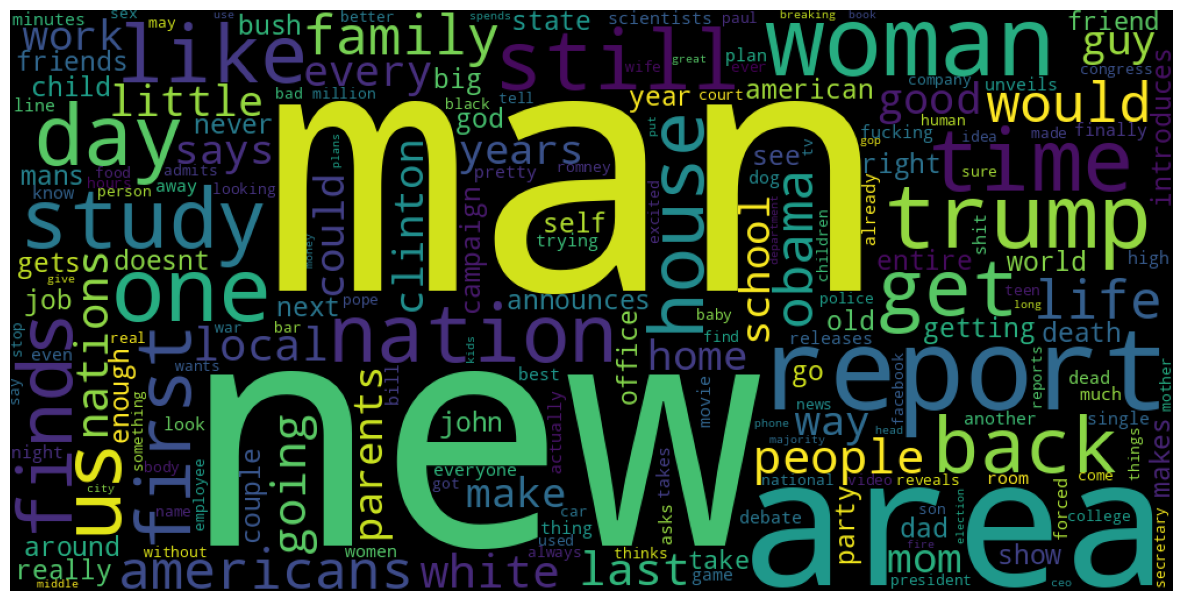

In [35]:
from collections import Counter
from wordcloud import WordCloud

pos_data = data[data['is_sarcastic'] == 1]
pos_head_lines = CleanTokenize(pos_data)
pos_lines = [j for sub in pos_head_lines for j in sub]
word_could_dict = Counter(pos_lines)

wordcloud = WordCloud(width=1000, height=500).generate_from_frequencies(word_could_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()



In [44]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

# Assuming CleanTokenize function is defined and returns the processed headlines
head_lines = CleanTokenize(data)  # Process all headlines

# Create a tokenizer and fit on all headlines
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(head_lines)
sequences = tokenizer_obj.texts_to_sequences(head_lines)

# Define max_length and vocabulary size
max_length = 25
word_index = tokenizer_obj.word_index
vocab_size = len(word_index) + 1

# Pad sequences
lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
sentiment = data['is_sarcastic'].values  # Sentiment for all headlines

# Shuffle data
indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
sentiment = sentiment[indices]

# Split into training and validation sets
validation_split = 0.2
num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
X_test_pad = lines_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

# Your further model training and evaluation steps go here


In [45]:
print("unique tokens - ", len(word_index))
print('vocab size -', vocab_size)


unique tokens -  28691
vocab size - 28692


In [46]:
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (44263, 25)
Shape of y_train: (44263,)
Shape of X_test_pad: (11065, 25)
Shape of y_test: (11065,)


In [47]:
embeddings_index = {}
embedding_dim = 100
GLOVE_DIR = "/content/sample_data"

with open(os.path.join(GLOVE_DIR, '/content/glove.twitter.27B.100d.txt'), encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [50]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Bidirectional, Dense

# Assuming you have the necessary data and embeddings prepared
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summarize the model
model.summary()

# Fit the model
model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=5, batch_size=64)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 25, 100)           2869200   
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               84480     
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2953809 (11.27 MB)
Trainable params: 84609 (330.50 KB)
Non-trainable params: 2869200 (10.95 MB)
_________________________________________________________________
Epoch 1/5
692/692 [==============================] - 87s 116ms/step - loss: 0.5866 - accuracy: 0.6805 - val_loss: 0.5504 - val_accuracy: 0.7081
Epoch 2/5
692/692 [==============================] - 78s 112ms/s

In [53]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train_pad, y_train, batch_size=32, epochs=25, validation_data=(X_test_pad, y_test), verbose=2, callbacks=[early_stopping])


Epoch 1/25
1384/1384 - 123s - loss: 0.4438 - accuracy: 0.7795 - val_loss: 0.4568 - val_accuracy: 0.7750 - 123s/epoch - 89ms/step
Epoch 2/25
1384/1384 - 122s - loss: 0.4283 - accuracy: 0.7901 - val_loss: 0.4455 - val_accuracy: 0.7867 - 122s/epoch - 88ms/step
Epoch 3/25
1384/1384 - 125s - loss: 0.4097 - accuracy: 0.8005 - val_loss: 0.4375 - val_accuracy: 0.7795 - 125s/epoch - 90ms/step
Epoch 4/25
1384/1384 - 122s - loss: 0.3962 - accuracy: 0.8076 - val_loss: 0.4275 - val_accuracy: 0.7978 - 122s/epoch - 88ms/step
Epoch 5/25
1384/1384 - 125s - loss: 0.3833 - accuracy: 0.8160 - val_loss: 0.4253 - val_accuracy: 0.8006 - 125s/epoch - 91ms/step
Epoch 6/25
1384/1384 - 126s - loss: 0.3717 - accuracy: 0.8222 - val_loss: 0.4169 - val_accuracy: 0.8077 - 126s/epoch - 91ms/step
Epoch 7/25
1384/1384 - 124s - loss: 0.3610 - accuracy: 0.8268 - val_loss: 0.4000 - val_accuracy: 0.8142 - 124s/epoch - 90ms/step
Epoch 8/25
1384/1384 - 127s - loss: 0.3497 - accuracy: 0.8346 - val_loss: 0.4115 - val_accuracy: 

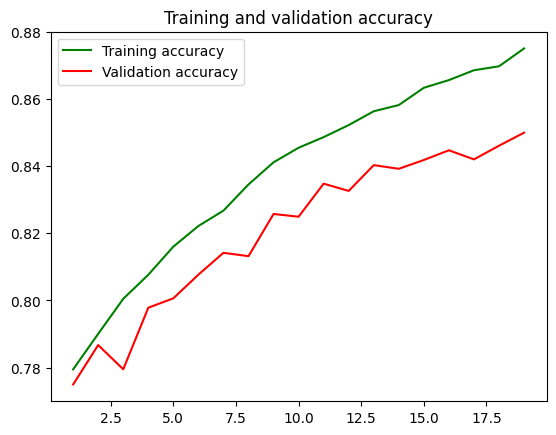

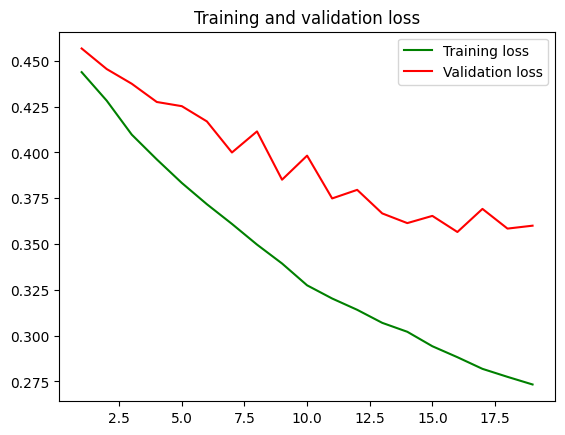

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [55]:
def predict_sarcasm(s, threshold=0.5):
    x_final = pd.DataFrame({"headline": [s]})
    test_lines = CleanTokenize(x_final)
    test_sequences = tokenizer_obj.texts_to_sequences(test_lines)
    test_review_pad = pad_sequences(test_sequences, maxlen=max_length, padding='post')
    pred = model.predict(test_review_pad)
    if pred[0][0] >= threshold:
        return "It's a sarcasm!"
    else:
        return "It's not a sarcasm."


In [60]:

predict_sarcasm("Oh great, another rainy day. Just what I needed!")

1/1 [==============================] - 0s 111ms/step


"It's a sarcasm!"

In [61]:
predict_sarcasm("I absolutely love being stuck in traffic for hours.")

1/1 [==============================] - 0s 98ms/step


"It's a sarcasm!"

In [62]:
predict_sarcasm("Wow, what a surprise, my favorite TV show got canceled.")

1/1 [==============================] - 0s 47ms/step


"It's not a sarcasm."

In [63]:
predict_sarcasm("Sure, because I have nothing better to do than listen to your complaints.")

1/1 [==============================] - 0s 131ms/step


"It's not a sarcasm."

In [64]:
predict_sarcasm("Fantastic, the printer broke down again just when I needed it most")

1/1 [==============================] - 0s 50ms/step


"It's not a sarcasm."

In [65]:
predict_sarcasm("I enjoy going for a walk in the park on a sunny day.")

1/1 [==============================] - 0s 109ms/step


"It's a sarcasm!"